## Final Project Submission

Please fill out:
* Student name: Devin Belden
* Student pace: full time
* Scheduled project review date/time: 	Fri Feb 7, 2020 1:30pm – 2:30pm (MST)
* Instructor name: James Irving, Ph.D.
* Blog post URL: TBD

# Business Case

For this project, we attempt to use existing data to predict the winners of chess matches, given such variables as the type of opening, game length, the ratings of the players, etc. This analysis, therefore, is for those coaches and professionals whom wish to have deeper insight into the patterns and behaviors behind wins and losses, such that those behaviors might be encouraged or mitigated as needed. 

The possible endings, underneath the column `winner`, are White, Black, and Draw; due to having three target classes, random guessing leads to an overall accuracy rating of 33%. We should then pick models that have an overall accuracy rating that is higher than this, and we should be sure to take into account model runtime as well.

# Importing, Exploration, and Preprocessing

First, we import relevant packages, as well as the dataset.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                     RandomizedSearchCV)

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (precision_score, recall_score, 
                             accuracy_score, f1_score)

from imblearn.over_sampling import ADASYN,SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier,RandomForestClassifier,
                              BaggingClassifier,GradientBoostingClassifier,
                              ExtraTreesClassifier)

from xgboost import XGBClassifier,XGBRFClassifier
from sklearn.svm import SVC
from sklearn.tree import export_graphviz
from IPython.display import Image  
from pydotplus import graph_from_dot_data

pd.options.display.float_format = '{:.2f}'.format

df = pd.read_csv('games.csv')
df.head()

Using TensorFlow backend.


id  rated       created_at     last_move_at  turns victory_status  \
0  TZJHLljE  False 1504210000000.00 1504210000000.00     13      outoftime   
1  l1NXvwaE   True 1504130000000.00 1504130000000.00     16         resign   
2  mIICvQHh   True 1504130000000.00 1504130000000.00     61           mate   
3  kWKvrqYL   True 1504110000000.00 1504110000000.00     61           mate   
4  9tXo1AUZ   True 1504030000000.00 1504030000000.00     95           mate   

  winner increment_code       white_id  white_rating      black_id  \
0  white           15+2       bourgris          1500          a-00   
1  black           5+10           a-00          1322     skinnerua   
2  white           5+10         ischia          1496          a-00   
3  white           20+0  daniamurashov          1439  adivanov2009   
4  white           30+3      nik221107          1523  adivanov2009   

   black_rating                                              moves  \
0          1191  d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...   
1          1261  d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...   
2          1500  e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...   
3          1454  d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...   
4          1469  e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...   

  opening_eco                            opening_name  opening_ply  
0         D10        Slav Defense: Exchange Variation            5  
1         B00  Nimzowitsch Defense: Kennedy Variation            4  
2         C20   King's Pawn Game: Leonardis Variation            3  
3         D02  Queen's Pawn Game: Zukertort Variation            3  
4         C41                        Philidor Defense            5

To reiterate (or perhaps as proof), the target column contains three unique values, and the data is whole and complete.

In [2]:
df.winner.unique()

array(['white', 'black', 'draw'], dtype=object)

In [3]:
df.isna().sum()

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64

The range of rankings of players in this dataset is very large, going from fairly low-ranked games (~800 ranking) to very high-level games (>2700). For reference, the lowest possible ranking is 100, and the highest possible ranking is, in theory, 3000. The current highest-ranked player in the world, Magnus Carlsen, is ranked 2845. 

In [4]:
print(df['white_rating'].min(), df['white_rating'].max())
print(df['black_rating'].min(), df['black_rating'].max())

784 2700
789 2723


## Dropping Features

As there is sufficient information contained in the columns regarding the opening moves, and due to the task of processing the data within `moves`, the decision was made to remove that column entirely, opting to use the opening of the match as any indication of moves taken within the game.

Additionally, there is next to no information within the `created_at` and `last_move_at` columns, as the source of the data truncated the last (and arguably most important) 7 digits of the time values. Those columns should be removed as well.

The column `victory_status` will be dropped as well, as failing to do so will introduce major bias to our analysis, e.g. "We knew the status of `winner` would be 'draw', as the entry in `victory_status` also said 'draw'". 

Finally, the `id` should be dropped, as it also offers no valuable information.

In [5]:
df.drop(['moves','created_at','last_move_at','id','victory_status'], axis=1, inplace=True)

In [6]:
df.head()

rated  turns winner increment_code       white_id  white_rating  \
0  False     13  white           15+2       bourgris          1500   
1   True     16  black           5+10           a-00          1322   
2   True     61  white           5+10         ischia          1496   
3   True     61  white           20+0  daniamurashov          1439   
4   True     95  white           30+3      nik221107          1523   

       black_id  black_rating opening_eco  \
0          a-00          1191         D10   
1     skinnerua          1261         B00   
2          a-00          1500         C20   
3  adivanov2009          1454         D02   
4  adivanov2009          1469         C41   

                             opening_name  opening_ply  
0        Slav Defense: Exchange Variation            5  
1  Nimzowitsch Defense: Kennedy Variation            4  
2   King's Pawn Game: Leonardis Variation            3  
3  Queen's Pawn Game: Zukertort Variation            3  
4                        Philidor Defense            5

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 11 columns):
rated             20058 non-null bool
turns             20058 non-null int64
winner            20058 non-null object
increment_code    20058 non-null object
white_id          20058 non-null object
white_rating      20058 non-null int64
black_id          20058 non-null object
black_rating      20058 non-null int64
opening_eco       20058 non-null object
opening_name      20058 non-null object
opening_ply       20058 non-null int64
dtypes: bool(1), int64(4), object(6)
memory usage: 1.5+ MB


## How Many Features Are There?

Next, we should get a feel for the dimensionality of our data, should we choose to one-hot encode it as is. 

In [8]:
total_cols = 0
for col in ['opening_eco','opening_name','opening_ply','white_id','black_id','increment_code']:
    total_cols += df[col].nunique()

total_cols

21034

One-hot encoding our categorical data as is would result in an increase in dimensionality of 21,034. Clearly we must pare this down to not only keep our interpretability high, but to keep our computational costs manageable. Additionally, given the former, let's hold off on using Principal Component Analysis until we've further explored the data.

Instead, let's try dropping a few columns that play no clear role in the classification models we'll use down the road.

In [9]:
df.drop(['white_id','black_id','opening_name'], axis=1, inplace=True)
df.head()

rated  turns winner increment_code  white_rating  black_rating opening_eco  \
0  False     13  white           15+2          1500          1191         D10   
1   True     16  black           5+10          1322          1261         B00   
2   True     61  white           5+10          1496          1500         C20   
3   True     61  white           20+0          1439          1454         D02   
4   True     95  white           30+3          1523          1469         C41   

   opening_ply  
0            5  
1            4  
2            3  
3            3  
4            5

Next we'll bin our `opening_eco` column by the letter category.

In [10]:
df['eco_category'] = df.apply(lambda row: row['opening_eco'][0], axis=1)
df.drop('opening_eco', axis=1, inplace=True)
df.head()

rated  turns winner increment_code  white_rating  black_rating  \
0  False     13  white           15+2          1500          1191   
1   True     16  black           5+10          1322          1261   
2   True     61  white           5+10          1496          1500   
3   True     61  white           20+0          1439          1454   
4   True     95  white           30+3          1523          1469   

   opening_ply eco_category  
0            5            D  
1            4            B  
2            3            C  
3            3            D  
4            5            C

While we're at it, we should map our target column to numerical values. We'll do this by order of decreasing appearance within the dataset.

In [11]:
df['winner'].value_counts(normalize=True)

white   0.50
black   0.45
draw    0.05
Name: winner, dtype: float64

In [12]:
winner_map = {
    "white": 0,
    "black": 1,
    "draw": 2
    }

df['winner'] = df['winner'].map(winner_map)
df.head()

rated  turns  winner increment_code  white_rating  black_rating  \
0  False     13       0           15+2          1500          1191   
1   True     16       1           5+10          1322          1261   
2   True     61       0           5+10          1496          1500   
3   True     61       0           20+0          1439          1454   
4   True     95       0           30+3          1523          1469   

   opening_ply eco_category  
0            5            D  
1            4            B  
2            3            C  
3            3            D  
4            5            C

## Class Imbalance

While we're here, let's take a moment to understand our class imbalance issue. Random guessing, as stated before, gives an overall accuracy of 33%. "Weighted guessing"--that is, putting 50% of our guesses as White, 45% of our guesses as Black, and 5% of our guesses as Draw--gives an overall accuracy of 45.5%. Further still, simply guessing every game as ending in White victory would net us 50%. We should then instead look for models that surpass this accuracy. 

## More Data Cleanup and One-Hot Encoding

Let's take care of the rest of the categorical column preprocessing before we one-hot encode them. We'll change `rated` from boolean to binary, and  change `increment_code` to display the starting time on the player clocks. After that, we'll be ready to encode our columns.

In [13]:
rated_map = {False: 0, True: 1}

df['rated'] = df['rated'].map(rated_map)
df.head()

rated  turns  winner increment_code  white_rating  black_rating  \
0      0     13       0           15+2          1500          1191   
1      1     16       1           5+10          1322          1261   
2      1     61       0           5+10          1496          1500   
3      1     61       0           20+0          1439          1454   
4      1     95       0           30+3          1523          1469   

   opening_ply eco_category  
0            5            D  
1            4            B  
2            3            C  
3            3            D  
4            5            C

In [14]:
df['game_time'] = df.apply(lambda row: row['increment_code'].split('+')[0], axis=1)
df['game_time'] = df['game_time'].astype('int64')
df.drop('increment_code', axis=1, inplace=True)
df.head()

rated  turns  winner  white_rating  black_rating  opening_ply eco_category  \
0      0     13       0          1500          1191            5            D   
1      1     16       1          1322          1261            4            B   
2      1     61       0          1496          1500            3            C   
3      1     61       0          1439          1454            3            D   
4      1     95       0          1523          1469            5            C   

   game_time  
0         15  
1          5  
2          5  
3         20  
4         30

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 8 columns):
rated           20058 non-null int64
turns           20058 non-null int64
winner          20058 non-null int64
white_rating    20058 non-null int64
black_rating    20058 non-null int64
opening_ply     20058 non-null int64
eco_category    20058 non-null object
game_time       20058 non-null int64
dtypes: int64(7), object(1)
memory usage: 1.2+ MB


In [16]:
df = pd.get_dummies(df, columns=['eco_category'])

df

rated  turns  winner  white_rating  black_rating  opening_ply  \
0          0     13       0          1500          1191            5   
1          1     16       1          1322          1261            4   
2          1     61       0          1496          1500            3   
3          1     61       0          1439          1454            3   
4          1     95       0          1523          1469            5   
...      ...    ...     ...           ...           ...          ...   
20053      1     24       0          1691          1220            2   
20054      1     82       1          1233          1196            2   
20055      1     35       0          1219          1286            3   
20056      1    109       0          1360          1227            4   
20057      1     78       1          1235          1339            3   

       game_time  eco_category_A  eco_category_B  eco_category_C  \
0             15               0               0               0   
1              5               0               1               0   
2              5               0               0               1   
3             20               0               0               0   
4             30               0               0               1   
...          ...             ...             ...             ...   
20053         10               1               0               0   
20054         10               1               0               0   
20055         10               0               0               0   
20056         10               0               1               0   
20057         10               0               0               0   

       eco_category_D  eco_category_E  
0                   1               0  
1                   0               0  
2                   0               0  
3                   1               0  
4                   0               0  
...               ...             ...  
20053               0               0  
20054               0               0  
20055               1               0  
20056               0               0  
20057               1               0  

[20058 rows x 12 columns]

# Preliminary Modeling

Now that we've got our data largely in the form we want, we can begin our modeling. We'll first define some functions that will help us train and evaluate the models.

In [17]:
y = df['winner']
X = df.drop('winner', axis=1)

def train_test(df=df, drop_cols=['winner']):
    
    """Takes in a DataFrame and any columns to drop from training
    data as inputs. Returns a train-test split of that data."""
    
    y = df['winner']
    X = df.drop(drop_cols, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    
    return X_train, X_test, y_train, y_test


def scale(df=df, drop_cols=['winner']):
    
    """Takes in a DataFrame and any columns to drop from training data
    as inputs. Returns a Standard Scaled train-test split."""
    
    scaler = StandardScaler()
    X_train, X_test, y_train, y_test = train_test(df=df, drop_cols=drop_cols)
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test) 
    
    return X_train_scaled, X_test_scaled, y_train, y_test


def smote(df=df, scaled=True, verbose=False, drop_cols=['winner']):
    
    """Takes in a DataFrame and any columns to drop from training data
    as inputs. Returns an oversampled train-test split. Optionally, will
    Standard Scale the data as well."""
    
    smote=SMOTE()
    
    if scaled:
        X_train, X_test, y_train, y_test = scale(df=df, drop_cols=drop_cols)
        X_train, y_train = smote.fit_sample(X_train, y_train)
        
    else:
        X_train, X_test, y_train, y_test = train_test(df=df, drop_cols=drop_cols)
        X_train, y_train = smote.fit_sample(X_train, y_train)
        
    if verbose:
        print(pd.Series(y_train).value_counts())
        print(pd.Series(y_test).value_counts())
        
    return X_train, X_test, y_train, y_test
    
    
def print_metrics(labels, preds):
    
    """Takes test labels and predicted labels as inputs.
    Returns precision, recall, accuracy, and f1 scores."""
    
    print(f"Precision Score: {precision_score(labels, preds, average=None)}")
    print(f"Recall Score: {recall_score(labels, preds, average=None)}")
    print(f"Accuracy Score: {accuracy_score(labels, preds)}")
    print(f"F1 Score: {f1_score(labels, preds, average=None)}")
    
    
def plot_importance(model,top_n=20,figsize=(10,10), drop_cols=['winner']):
    
    """Returns a plot of features ranked by their importance, listed from
    most to least important."""
    
    df_importance = pd.Series(model.feature_importances_,
                              index=df.drop(drop_cols, axis=1).columns)
    df_importance.sort_values(ascending=True).tail(top_n).plot(
        kind='barh',figsize=figsize)
    return df_importance

## Vanilla KNN

In [18]:
X_train, X_test, y_train, y_test = scale()

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

test_preds = clf.predict(X_test)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.7174100910722595
0.5794616151545364


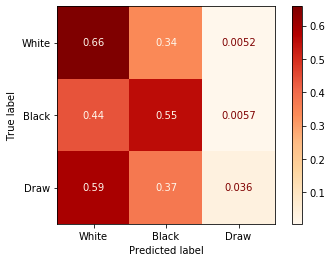

In [19]:
import seaborn as sns



plot_confusion_matrix(clf, X_test, y_test, normalize='true', display_labels=['White','Black','Draw'], cmap='OrRd');

### KNN With SMOTE

In [20]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

test_preds = clf.predict(X_test)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

2    7472
1    7472
0    7472
dtype: int64
0    2529
1    2233
2     253
Name: winner, dtype: int64
0.7863579586009993
0.5136590229312064


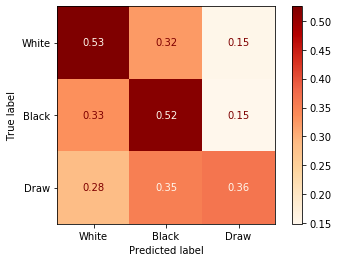

In [21]:
plot_confusion_matrix(clf, X_test, y_test, normalize='true', display_labels=['White','Black','Draw'], cmap='OrRd')

With SMOTE, we've gained a much higher degree of homogeneity at the cost of overall accuracy and overfitting. Let's try a different model.

## Vanilla Decision Tree

In [22]:
tree = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

tree.fit(X_train, y_train)

test_preds = tree.predict(X_test)

print(tree.score(X_train, y_train))
print(tree.score(X_test, y_test))

2    7514
1    7514
0    7514
dtype: int64
0    2487
1    2281
2     247
Name: winner, dtype: int64
1.0
0.5509471585244268


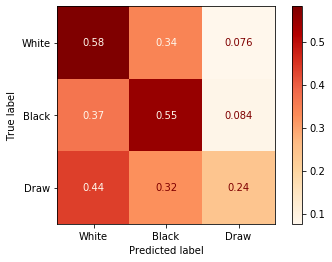

In [23]:
plot_confusion_matrix(tree, X_test, y_test, normalize='true', display_labels=['White','Black','Draw'], cmap='OrRd')

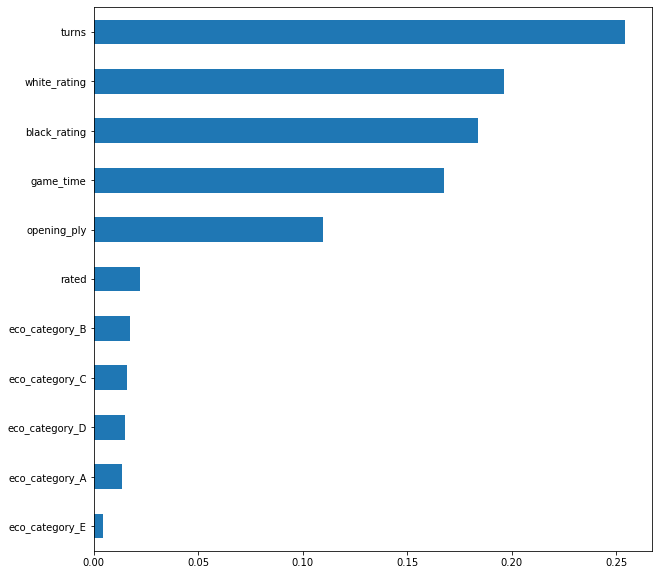

In [24]:
plot_importance(tree.fit(X_train, y_train));

### Low Depth Decision Tree

2    7515
1    7515
0    7515
dtype: int64
0    2486
1    2274
2     255
Name: winner, dtype: int64
0.6703925482368596
0.5308075772681954


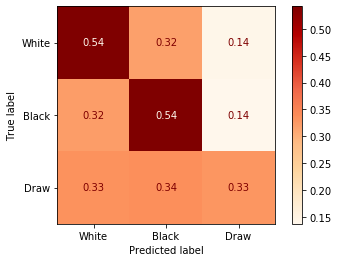

In [25]:
tree = DecisionTreeClassifier(max_depth=10)
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

tree.fit(X_train, y_train)

test_preds = tree.predict(X_test)

print(tree.score(X_train, y_train))
print(tree.score(X_test, y_test))

plot_confusion_matrix(tree, X_test, y_test, normalize='true', display_labels=['White','Black','Draw'], cmap='OrRd')

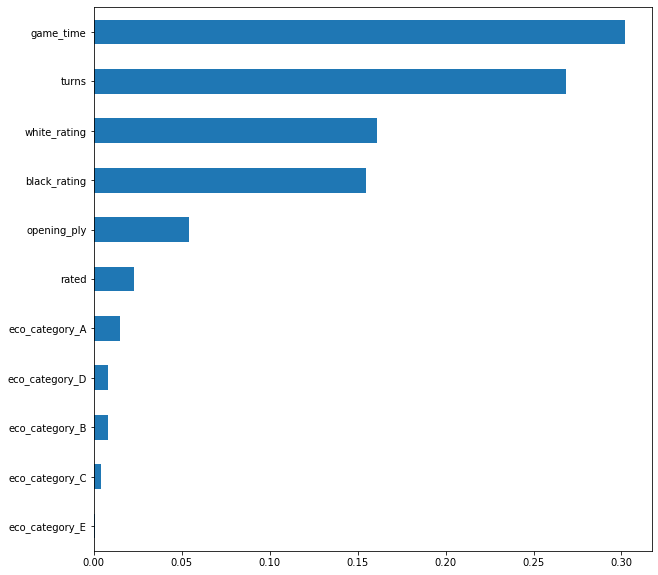

In [26]:
plot_importance(tree.fit(X_train, y_train));

## Vanilla Bagging

In [27]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

bag = BaggingClassifier(n_estimators=100)
bag.fit(X_train, y_train)
print(bag.score(X_train, y_train))
print(bag.score(X_test, y_test))

2    7538
1    7538
0    7538
dtype: int64
0    2463
1    2315
2     237
Name: winner, dtype: int64
1.0
0.6017946161515454


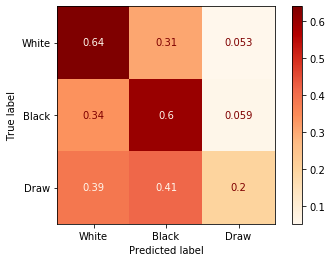

In [28]:
plot_confusion_matrix(bag, X_test, y_test, normalize='true', display_labels=['White','Black','Draw'], cmap='OrRd')

## Vanilla Random Forest

In [29]:
# bootstrap aggregation is an improvement over KNN. Let's try RF
X_train, X_test, y_train, y_test = smote(scaled=False, verbose=True)

rf = RandomForestClassifier()

rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

2    7468
1    7468
0    7468
dtype: int64
0    2533
1    2251
2     231
Name: winner, dtype: int64
1.0
0.6406779661016949


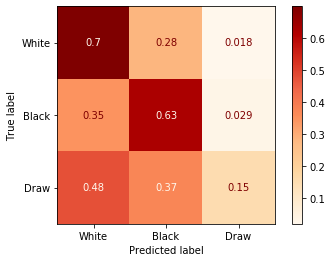

In [30]:
plot_confusion_matrix(rf, X_test, y_test, normalize='true', display_labels=['White','Black','Draw'], cmap='OrRd')

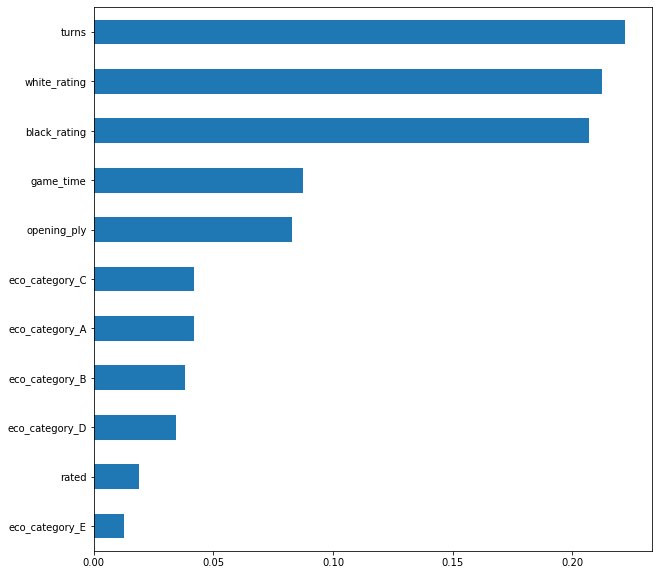

In [31]:
plot_importance(rf.fit(X_train, y_train));

### Low Depth Random Forest

In [32]:
rf = RandomForestClassifier(max_depth=10)

rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.783252990537404
0.6161515453639083


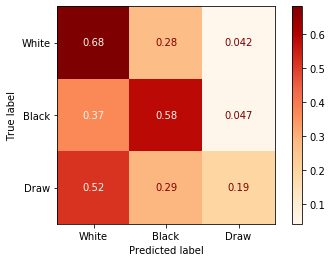

In [33]:
plot_confusion_matrix(rf, X_test, y_test, normalize='true', display_labels=['White','Black','Draw'], cmap='OrRd')

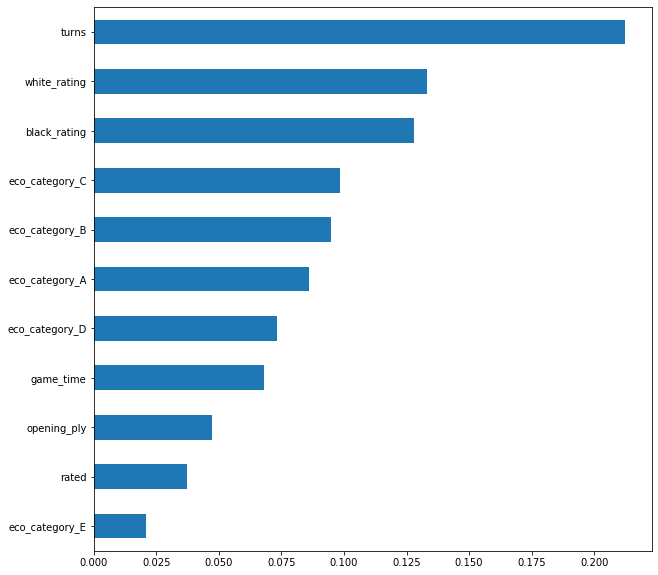

In [34]:
plot_importance(rf.fit(X_train, y_train));

## Low Depth Extra Trees

In [35]:
X_train, X_test, y_train, y_test = smote(scaled=False, verbose=True)

et = ExtraTreesClassifier(n_estimators=100, max_depth=10)
et.fit(X_train, y_train)

print(et.score(X_train, y_train))
print(et.score(X_test, y_test))

2    7525
1    7525
0    7525
dtype: int64
0    2476
1    2297
2     242
Name: winner, dtype: int64
0.7035215946843854
0.6001994017946162


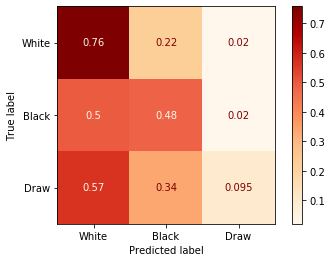

In [36]:
plot_confusion_matrix(et, X_test, y_test, normalize='true', display_labels=['White','Black','Draw'], cmap='OrRd')

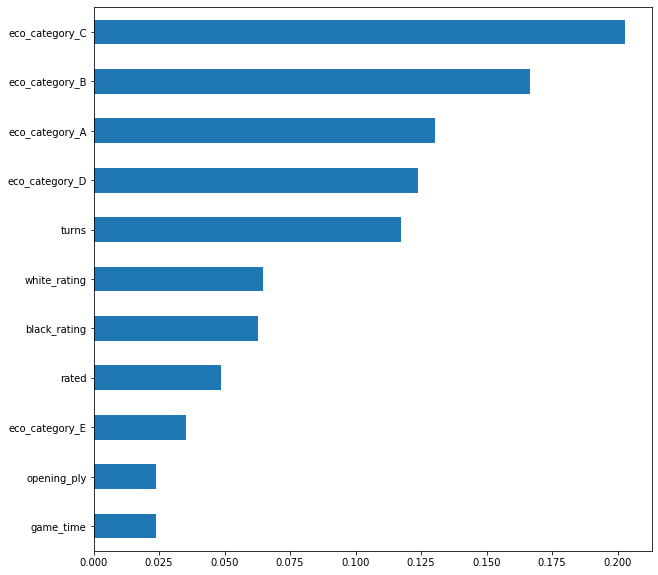

In [37]:
plot_importance(et.fit(X_train, y_train));

## Support Vector Machines

2    7532
1    7532
0    7532
dtype: int64
0    2469
1    2289
2     257
Name: winner, dtype: int64
0.6234289254735351
0.5371884346959123


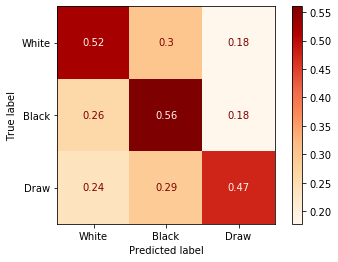

In [38]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

clf = SVC(gamma='auto', C=10)
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

plot_confusion_matrix(clf, X_test, y_test, normalize='true', display_labels=['White','Black','Draw'], cmap='OrRd')

0.5500973623650204
0.5234297108673978
0.5755885997521685
0.5274177467597209
0.3971941936625952
0.39740777666999005


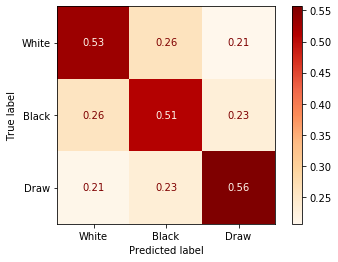

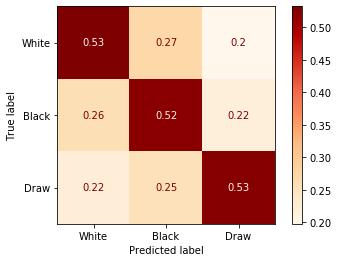

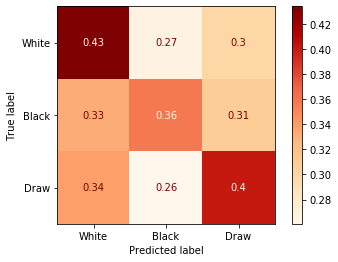

In [39]:
kernels = ['linear','poly','sigmoid']

for kernel in kernels:

    clf = SVC(gamma='auto', kernel=kernel)
    clf.fit(X_train, y_train)
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))
    plot_confusion_matrix(clf, X_test, y_test, normalize='true', display_labels=['White','Black','Draw'], cmap='OrRd')

# Ensemble Methods

## AdaBoost With Low Depth Random Forest

2    7547
1    7547
0    7547
dtype: int64
0    2454
1    2321
2     240
Name: winner, dtype: int64
0.8938209443045801
0.6568295114656032


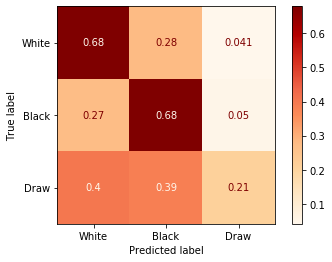

In [40]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

ada = AdaBoostClassifier(RandomForestClassifier(max_depth=10), learning_rate=0.1)
ada.fit(X_train, y_train)
print(ada.score(X_train, y_train))
print(ada.score(X_test, y_test))

plot_confusion_matrix(ada, X_test, y_test, normalize='true', display_labels=['White','Black','Draw'], cmap='OrRd')

## Max Depth Gradient Boost

2    7457
1    7457
0    7457
dtype: int64
0    2544
1    2223
2     248
Name: winner, dtype: int64
1.0
0.6536390827517448


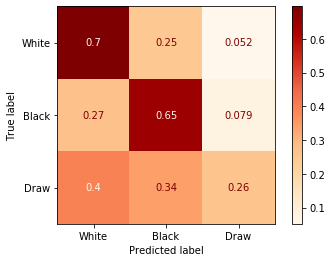

In [41]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

grad = GradientBoostingClassifier(max_depth=None)
grad.fit(X_train, y_train)
print(grad.score(X_train, y_train))
print(grad.score(X_test, y_test))

plot_confusion_matrix(grad, X_test, y_test, normalize='true', display_labels=['White','Black','Draw'], cmap='OrRd')

### Low Depth Gradient Boost

2    7481
1    7481
0    7481
dtype: int64
0    2520
1    2267
2     228
Name: winner, dtype: int64
0.9860090005792452
0.8103688933200399


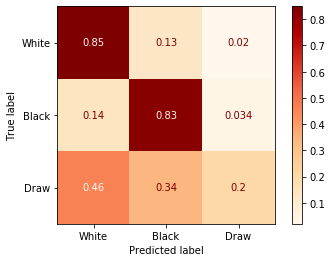

In [42]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

grad = GradientBoostingClassifier(max_depth=10)
grad.fit(X_train, y_train)
print(grad.score(X_train, y_train))
print(grad.score(X_test, y_test))

plot_confusion_matrix(grad, X_test, y_test, normalize='true', display_labels=['White','Black','Draw'], cmap='OrRd')

### Low Depth Gradient Boost with Gridsearch

So far, the Gradient Boosting algorithm, while still quite unable to accurately predict 'Draw' endings, has produced the highest degree of overall test accuracy, albeit somewhat overfitting to the training data. After looking at more ensemble methods, it would be worth pursuing hyperparameter tuning for this model, in order to either increase the generalizability, or to increase test accuracy for 'Draw' outcomes. In discussing which parameters to tune, and which value choices to give the gridsearch algorithm, it is worth mentioning that, as the dataset contains over 20,000 rows, the samples required to create a new split or leaf in our gradient boosted random forest should be increased. Additionally, the maximum tree depth should be limited so as to prevent our previous case of overfitting. Finally, the learning rate will be tweaked in the aim of attaining a higher degree of granularity in the gradient descent.

In [43]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

go_ahead = input("Cell will take several minutes to run. Do you wish to run this cell (y/n)? ")

if go_ahead == 'y':

    grad = GradientBoostingClassifier()
    grid = {'learning_rate': [0.1,0.01],
            'max_depth': [3,5,10],
            'min_samples_split':[20,30,50],
            'min_samples_leaf':[10,30]}

    gridsearch = GridSearchCV(grad, param_grid=grid, cv=5)

    grad_cv = gridsearch.fit(X_train, y_train)
    
    best_params = grad_cv.best_params_

    print(best_params)
    
else:
    
    best_params = {'learning_rate': 0.1, 
                   'max_depth': 10, 
                   'min_samples_leaf': 10, 
                   'min_samples_split': 20}
    
    print(best_params)

2    7450
1    7450
0    7450
dtype: int64
0    2551
1    2239
2     225
Name: winner, dtype: int64
Cell will take several minutes to run. Do you wish to run this cell (y/n)? n
{'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 20}


In [44]:
grad = GradientBoostingClassifier(**best_params)
grad.fit(X_train, y_train)
print(grad.score(X_train, y_train))
print(grad.score(X_test, y_test))

0.959910514541387
0.8111665004985045


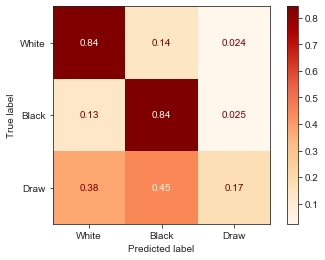

In [45]:
sns.set_style(style='ticks')
plot_confusion_matrix(grad, X_test, y_test, normalize='true', display_labels=['White','Black','Draw'], cmap='OrRd')

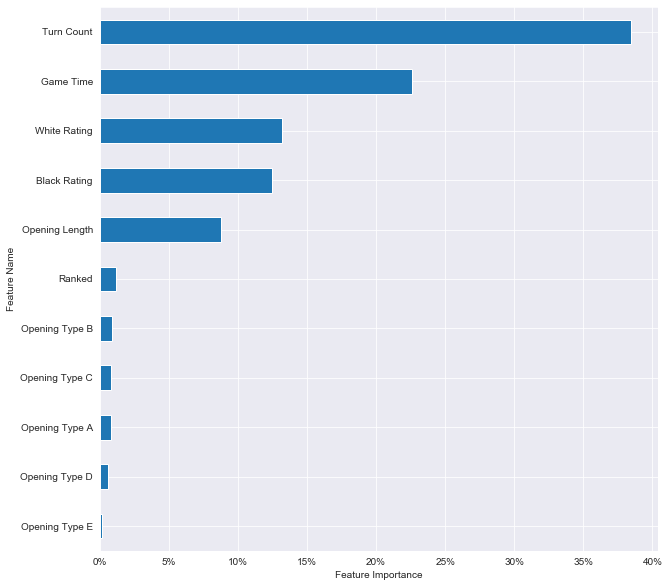

In [46]:
sns.set_style(style='darkgrid')
plot_importance(grad.fit(X_train, y_train))
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.xticks(ticks=[0,.05,.1,.15,.2,.25,.3,.35,.4], 
           labels=['0%','5%','10%','15%','20%','25%','30%','35%','40%'])

plt.yticks(ticks=range(11), 
           labels=['Opening Type E','Opening Type D','Opening Type A','Opening Type C',
                   'Opening Type B','Ranked','Opening Length','Black Rating','White Rating',
                  'Game Time','Turn Count'])
plt.show()

A gridsearch of hyperparameters has resulted in an accuracy increase of less than 1%. A bit underwhelming, especially given the time it took the gridsearch to run, but the level of overfit has gone down somewhat. Regardless, let's try a few other prediction methods.

Text(0.5, 1.0, 'Average Turn Count Per Outcome')

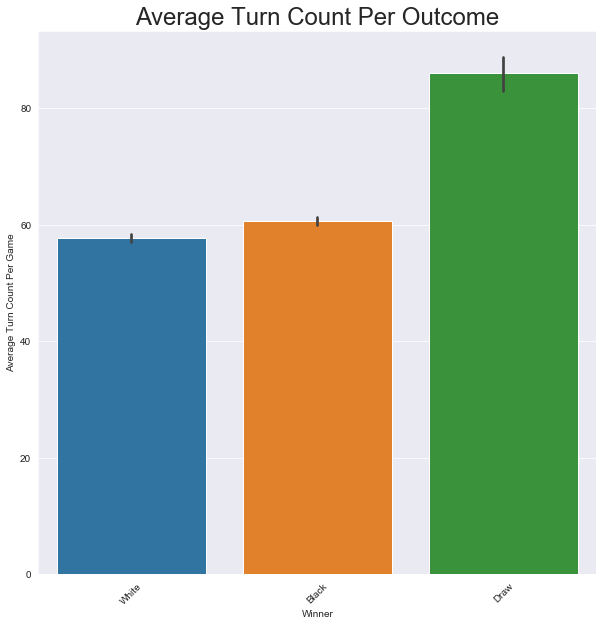

In [47]:
plt.figure(figsize=(10,10))
sns.barplot(y=df['turns'], x=df['winner'])
sns.set_context('poster')
plt.xlabel("Winner")
plt.xticks(ticks=range(3), labels=['White','Black','Draw'], rotation=45)
plt.ylabel("Average Turn Count Per Game")
plt.title("Average Turn Count Per Outcome")

Text(0.5, 1.0, 'Average Starting Game Time Per Outcome')

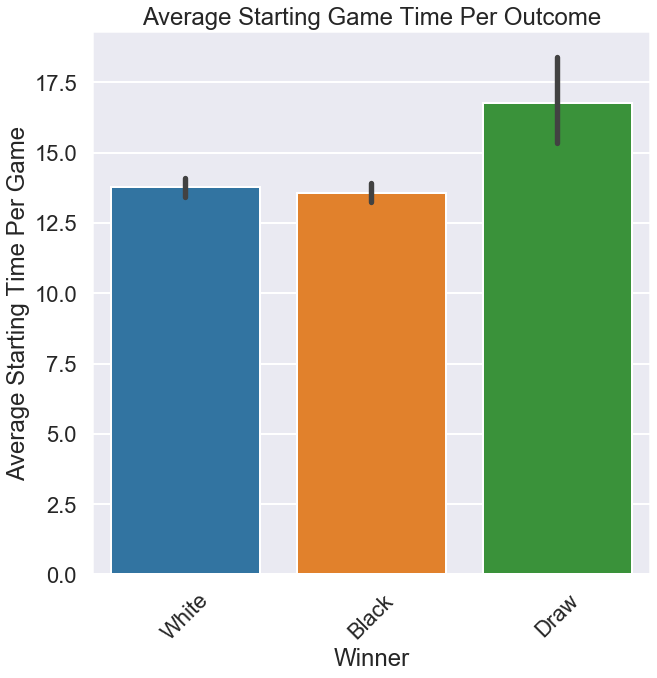

In [48]:
plt.figure(figsize=(10,10))
sns.barplot(y=df['game_time'], x=df['winner'])
sns.set_context('poster')
plt.xlabel("Winner")
plt.xticks(ticks=range(3), labels=['White','Black','Draw'], rotation=45)
plt.ylabel("Average Starting Time Per Game")
plt.title("Average Starting Game Time Per Outcome")

## Vanilla XGBoost

In [49]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

xgb_rf = XGBRFClassifier()
xgb_rf.fit(X_train, y_train)
print(xgb_rf.score(X_train, y_train))
print(xgb_rf.score(X_test,y_test))

2    7521
1    7521
0    7521
dtype: int64
0    2480
1    2276
2     259
Name: winner, dtype: int64
0.5661924389487214
0.5226321036889332


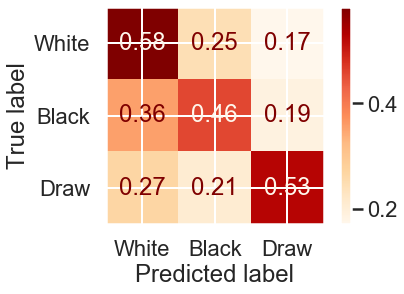

In [50]:

plot_confusion_matrix(xgb_rf, X_test, y_test, normalize='true', display_labels=['White','Black','Draw'], cmap='OrRd')

### High Depth XGBoost

While a max depth of 10 is low for a regular decision tree, it is rather high for an XGBoost algorithm. We'll use that depth here.

In [51]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

xgb_rf = XGBRFClassifier(max_depth=10)
xgb_rf.fit(X_train, y_train)
print(xgb_rf.score(X_train, y_train))
print(xgb_rf.score(X_test,y_test))

2    7512
1    7512
0    7512
dtype: int64
0    2489
1    2270
2     256
Name: winner, dtype: int64
0.7663294284700035
0.6071784646061814


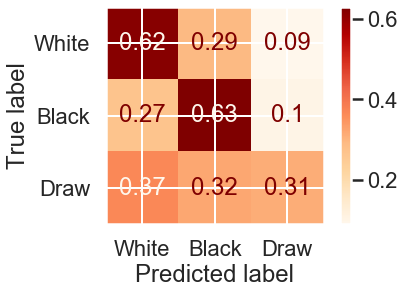

In [52]:
plot_confusion_matrix(xgb_rf, X_test, y_test, normalize='true', display_labels=['White','Black','Draw'], cmap='OrRd')

Text(0, 0.5, 'Feature Name')

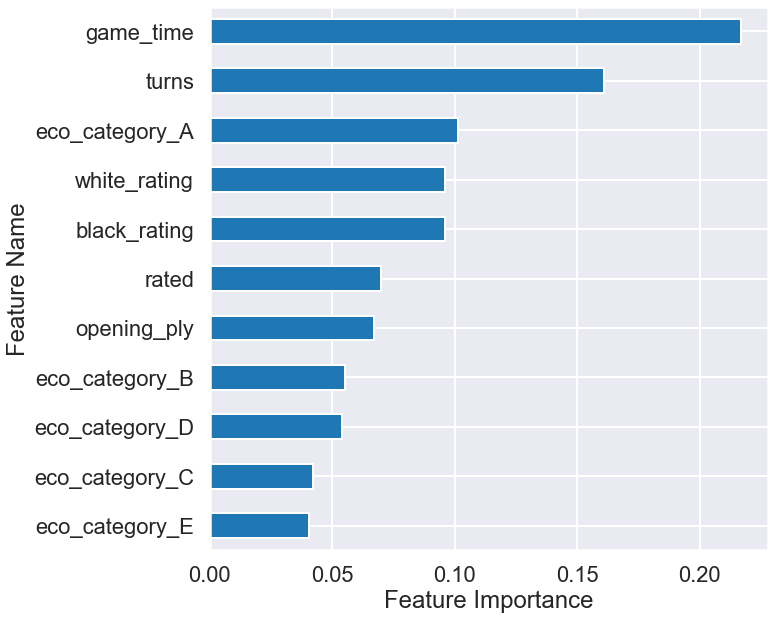

In [53]:
plot_importance(xgb_rf.fit(X_train, y_train))
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")

## Random Forest With Gridsearch

In [54]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

2    7494
1    7494
0    7494
dtype: int64
0    2507
1    2281
2     227
Name: winner, dtype: int64


In [55]:
go_ahead = input("Cell will take several minutes to run. Do you wish to run this cell (y/n)? ")

if go_ahead == 'y':

    rf_clf = RandomForestClassifier()
    grid = {'max_depth': [3,5,10,None],
            'criterion': ['gini','entropy'],
            'min_samples_split':[20,30,50],
            'min_samples_leaf':[10,30]}

    gridsearch = GridSearchCV(rf_clf, param_grid=grid, cv=5)

    forest_cv = gridsearch.fit(X_train, y_train)
    
    best_params = forest_cv.best_params_

    print(best_params)
    
else:
    
    best_params = {'criterion': 'gini', 
                   'max_depth': 10, 
                   'max_features': 3, 
                   'min_samples_leaf': 1, 
                   'min_samples_split': 2}
    
    print(best_params)

Cell will take several minutes to run. Do you wish to run this cell (y/n)? n
{'criterion': 'gini', 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [56]:
forest = RandomForestClassifier(**best_params)
forest.fit(X_train, y_train)

print(forest.score(X_train, y_train))
print(forest.score(X_test, y_test))

0.7369006316164043
0.5744765702891326


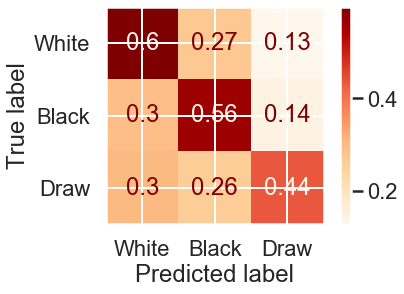

In [57]:
plot_confusion_matrix(forest, X_test, y_test, normalize='true', display_labels=['White','Black','Draw'], cmap='OrRd')

Text(0, 0.5, 'Feature Name')

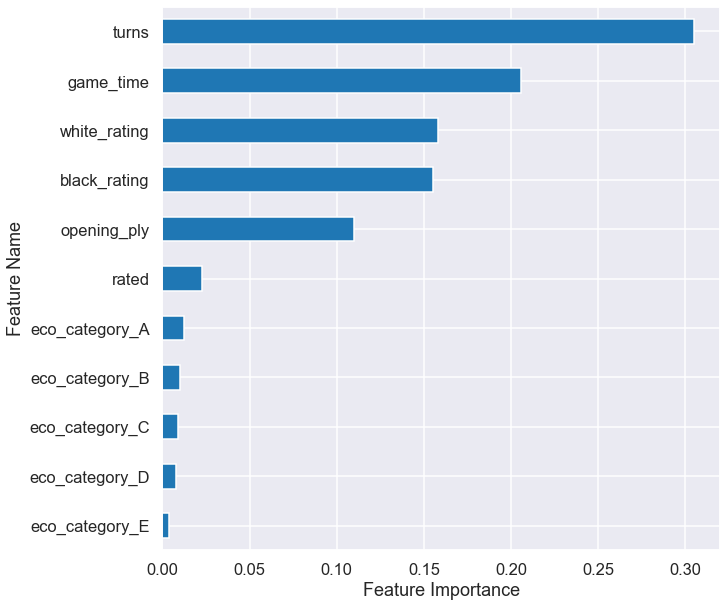

In [58]:
sns.set_context('talk')
plot_importance(forest.fit(X_train, y_train))
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")

### Single Tree With Gridsearch Parameters

In [59]:
X_train, X_test, y_train, y_test = smote(scaled=True, verbose=True)

tree = DecisionTreeClassifier(**best_params)

tree.fit(X_train, y_train)

print(tree.score(X_train, y_train))
print(tree.score(X_test, y_test))

2    7504
1    7504
0    7504
dtype: int64
0    2497
1    2289
2     229
Name: winner, dtype: int64
0.6094083155650319
0.47357926221335994


In [60]:
dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=X.columns,  
                           class_names=y.unique().astype('str'), 
                           filled=True, rounded=True, special_characters=True,
                           rotate=True)

graph = graph_from_dot_data(dot_data)  

Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.681907 to fit



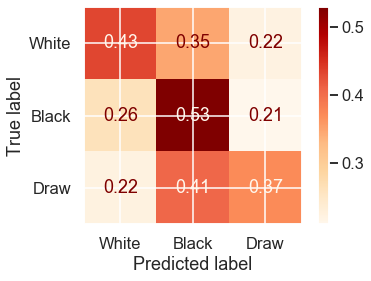

In [61]:
plot_confusion_matrix(tree, X_test, y_test, normalize='true', display_labels=['White','Black','Draw'], cmap='OrRd')

# Which Model is Best?

After running what seems like a dozen or more models, the next task is to choose the best one. Judging by raw accuracy, this seems to be the Gradient Boosted Random Forest; an overall accuracy of over 80% is extremely impressive, and no other model appears to even come close to this value. While its success of predicting draws is not something to write home about, this can most likely be remedied by procuring more data about draws. 

# Conclusion and Recommendations

Using a Gradient Boosted Random Forest model allows us to predict the endings of chess matches with over 80% accuracy, nearly twice as accurate as weighted guessing, and nearly 2.5 times as accurate as random guessing. Additionally, the model considers the turn count and the starting game time to account for 58% of its prediction. Draws are somewhat difficult to predict, perhaps owing to their relative rarity compared to either player winning outright, but further exploration of stalemate games might remedy this as well.

In discussing the results of the Gradient Boosted Random Forest model's predictions, two possible recommendations for players and/or coaches would be to point out that longer game times generally lead to Draws, and higher move counts generally favor Black, with the highest move counts also encouraging Draws. For example, when playing as Black, aiming to extend the game's turn count will give a statistical advantage.